# Riskfolio-Lib Tutorial: 
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.orenj-i.net)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
<a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 

## Tutorial 18: Multi Assets Algorithmic Trading Backtesting with Vectorbt

## 1. Downloading the data:

In [1]:
import os
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import vectorbt as vbt  # version=0.16.1
import yfinance as yf
from vectorbt.portfolio.enums import SizeType, Direction
from vectorbt.portfolio.nb import order_nb, sort_call_seq_nb

os.environ['NUMBA_DISABLE_JIT'] = '1'  # uncomment this if you want to use pypfopt within simulation

warnings.filterwarnings("ignore")

# Date range
start = '2000-01-01'
end = '2020-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM', 'ZION']
assets.sort()

# Downloading data
data = yf.download(assets, start=start, end=end)
data = data.loc[:, ('Close', slice(None))]
data.columns = assets

display(data.head())

[*********************100%***********************]  9 of 9 completed


APA      CMCSA      CPB  ...       MO       TGT     ZION
Date                                       ...                            
2000-01-03  14.772727  15.583333  37.2500  ...  23.4375  36.03125  55.5000
2000-01-04  14.123377  14.416667  35.8750  ...  23.6250  34.46875  52.8125
2000-01-05  14.529221  14.041667  35.5625  ...  23.5000  33.68750  52.7500
2000-01-06  15.909091  14.583333  36.3125  ...  23.0625  32.09375  53.5000
2000-01-07  15.854978  14.125000  37.0000  ...  23.6875  33.75000  53.6250

[5 rows x 9 columns]

## 2 Building the Backtest Function with Vectorbt 

### 2.1 Building Auxiliary Functions for Rebalancing

In [2]:
vbt.settings.returns['year_freq'] = '252 days'
vbt.settings.array_wrapper['freq'] = 'days'
vbt.settings.portfolio.stats['incl_unrealized'] = True
vbt.settings.portfolio['seed'] = 42


def pre_sim_func_nb(c, every_nth):
    # Define rebalancing days
    c.segment_mask[:, :] = False
    c.segment_mask[every_nth::every_nth, :] = True
    return ()


def pre_segment_func_nb(c, find_weights_nb, rm, history_len, srb_sharpe):
    if history_len == -1:
        # Look back at the entire time period
        close = c.close[:c.i, c.from_col:c.to_col]
    else:
        # Look back at a fixed time period
        if c.i - history_len <= 0:
            return (np.full(c.group_len, np.nan),)  # insufficient data
        close = c.close[c.i - history_len:c.i, c.from_col:c.to_col]

    # Find optimal weights
    best_sharpe_ratio, weights = find_weights_nb(c, rm, close)
    srb_sharpe[c.i] = best_sharpe_ratio

    # Update valuation price and reorder orders
    size_type = np.full(c.group_len, SizeType.TargetPercent)
    direction = np.full(c.group_len, Direction.LongOnly)
    order_value_out = np.empty(c.group_len, dtype=np.float_)
    for k in range(c.group_len):
        col = c.from_col + k
        c.last_val_price[col] = c.close[c.i, col]
    sort_call_seq_nb(c, weights, size_type, direction, order_value_out)

    return (weights,)


# Update fees/slipage according to your exchange.
def order_func_nb(oc, weights):
    col_i = oc.call_seq_now[oc.call_idx]
    return order_nb(
        size=weights[col_i],
        size_type=SizeType.TargetPercent,
        price=oc.close[oc.i, oc.col],
        fees=0,
        slippage=0,
        fixed_fees=0
    )

### 2.2 Building the Optimization Function

In [3]:
import riskfolio as rp
import riskfolio.RiskFunctions as rk


def riskfolio_find_weights(c, rm, close):
    # Calculate expected returns and sample covariance matrix
    close = pd.DataFrame(close, columns=assets)
    returns = close.pct_change().dropna()

    # Building the portfolio object
    port = rp.Portfolio(returns=returns)
    # Calculating optimum portfolio

    # Select method and estimate input parameters:

    method_mu = 'hist'  # Method to estimate expected returns based on historical data.
    method_cov = 'hist'  # Method to estimate covariance matrix based on historical data.

    port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

    # Estimate optimal portfolio:

    model = 'Classic'  # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
    rm = rm  # Risk measure used, this time will be variance
    obj = 'Sharpe'  # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
    hist = True  # Use historical scenarios for risk measures that depend on scenarios
    rf = 0  # Risk free rate
    l = 0  # Risk aversion factor, only useful when obj is 'Utility'

    w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
    weights = np.ravel(w.to_numpy())
    shp = rk.Sharpe(w, port.mu, cov=port.cov, returns=returns, rm=rm, rf=0, alpha=0.05)

    return shp, weights

## 3 Building Strategies with Vectorbt

### 3.1 Optimizing Portfolios each Rebalancing Date

In [4]:
% % time

# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded returns.
# 'UCI': Ulcer Index of uncompounded returns.

rms = ["MV", "CVaR", "WR", "CDaR"]

sharpe = {}
portfolio = {}

for i in rms:
    sharpe[i] = np.full(data.shape[0], np.nan)
    # Run simulation with a custom order function (Numba should be disabled)
    portfolio[i] = vbt.Portfolio.from_order_func(
        data,
        order_func_nb,
        pre_sim_func_nb=pre_sim_func_nb,
        pre_sim_args=(30,),
        pre_segment_func_nb=pre_segment_func_nb,
        pre_segment_args=(riskfolio_find_weights, i, 252 * 4, sharpe[i]),
        cash_sharing=True,
        group_by=True,
        freq='D',
    )

CPU times: user 1min 34s, sys: 1min 1s, total: 2min 36s
Wall time: 1min 33s


### 3.2 Plotting Portfolio Composition each Rebalancing Date

In [5]:
def plot_allocation(rb_pf):
    # Plot weights development of the portfolio
    rb_asset_value = rb_pf.asset_value(group_by=False)
    rb_value = rb_pf.value()
    rb_idxs = np.flatnonzero((rb_pf.asset_flow() != 0).any(axis=1))
    rb_dates = rb_pf.wrapper.index[rb_idxs]
    fig = (rb_asset_value.vbt / rb_value).vbt.plot(
        trace_names=assets,
        trace_kwargs=dict(
            stackgroup='one'
        )
    )
    for rb_date in rb_dates:
        fig.add_shape(
            dict(
                xref='x',
                yref='paper',
                x0=rb_date,
                x1=rb_date,
                y0=0,
                y1=1,
                line_color=fig.layout.template.layout.plot_bgcolor
            )
        )
    fig.show()


for i in rms:
    plot_allocation(portfolio[i])

### 3.3 Plotting Portfolio Values

<AxesSubplot:>

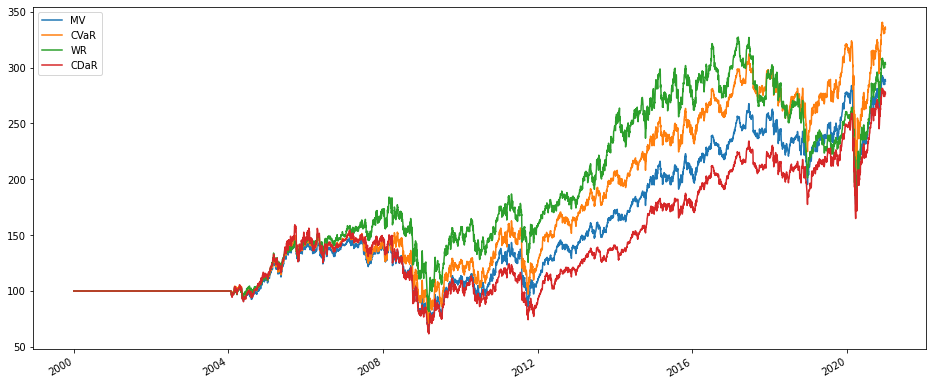

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(16, 7))

values = pd.DataFrame([])
for i in rms:
    a = portfolio[i].value()
    values = pd.concat([values, a], axis=1)

values.columns = rms

values.plot(ax=ax)

### 3.4 Portfolio Stats

In [7]:
stats = pd.DataFrame([])
for i in rms:
    a = portfolio[i].stats()
    stats = pd.concat([stats, a], axis=1)

stats.columns = rms
display(stats)

MV  ...                         CDaR
Start                                2000-01-03 00:00:00  ...          2000-01-03 00:00:00
End                                  2020-12-29 00:00:00  ...          2020-12-29 00:00:00
Period                                5282 days 00:00:00  ...           5282 days 00:00:00
Start Value                                          100  ...                          100
End Value                                        287.891  ...                      276.702
Total Return [%]                                 187.891  ...                      176.702
Benchmark Return [%]                             105.716  ...                      105.716
Max Gross Exposure [%]                               100  ...                          100
Total Fees Paid                                        0  ...                            0
Max Drawdown [%]                                 57.9405  ...                       61.308
Max Drawdown Duration                 1506 days 00:00:00  ...           2289 days 00:00:00
Total Trades                                         640  ...                          459
Total Closed Trades                                  631  ...                          451
Total Open Trades                                      9  ...                            8
Open Trade PnL                                   67.6872  ...                      68.6088
Win Rate [%]                                     57.8447  ...                      63.4146
Best Trade [%]                                    70.254  ...                      71.7981
Worst Trade [%]                                 -75.1589  ...                     -60.3188
Avg Winning Trade [%]                            11.2702  ...                      14.4308
Avg Losing Trade [%]                            -12.1461  ...                     -9.14928
Avg Winning Trade Duration  1526 days 09:12:19.726027408  ...  444 days 00:30:12.587412592
Avg Losing Trade Duration   1624 days 01:26:36.992481200  ...  253 days 05:55:19.480519480
Profit Factor                                     1.9331  ...                      1.87706
Expectancy                                      0.190498  ...                     0.220155
Sharpe Ratio                                    0.345194  ...                     0.333957
Calmar Ratio                                   0.0893028  ...                    0.0811561
Omega Ratio                                      1.07646  ...                      1.07339
Sortino Ratio                                   0.480857  ...                     0.466435

[28 rows x 4 columns]